In [36]:
import numpy as np
import pandas as pd #manipulation des données, calculs.
import pandas_datareader.data as web #téléchargement de données financières via API.
import matplotlib.pyplot as plt
from matplotlib import style 
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime as dt

C:\Users\alexa\AppData\Local\Temp\ipykernel_28264\3805599055.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start, end)
[*********************100%***********************]  1 of 1 completed


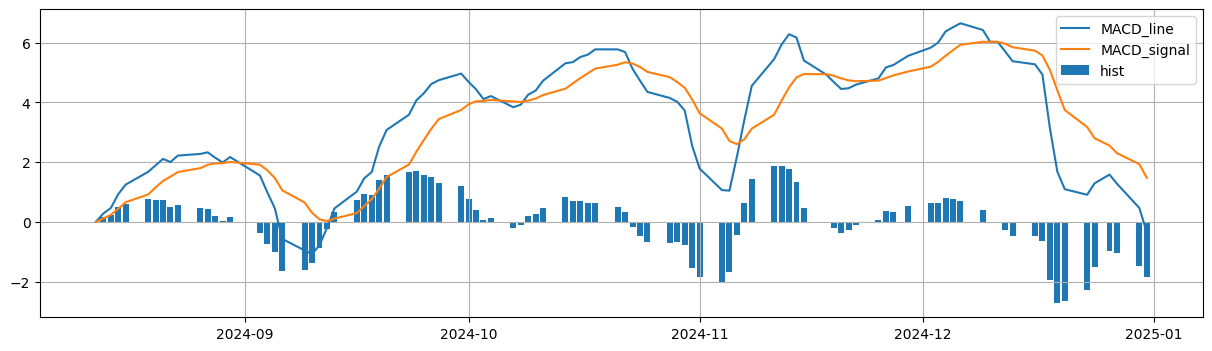

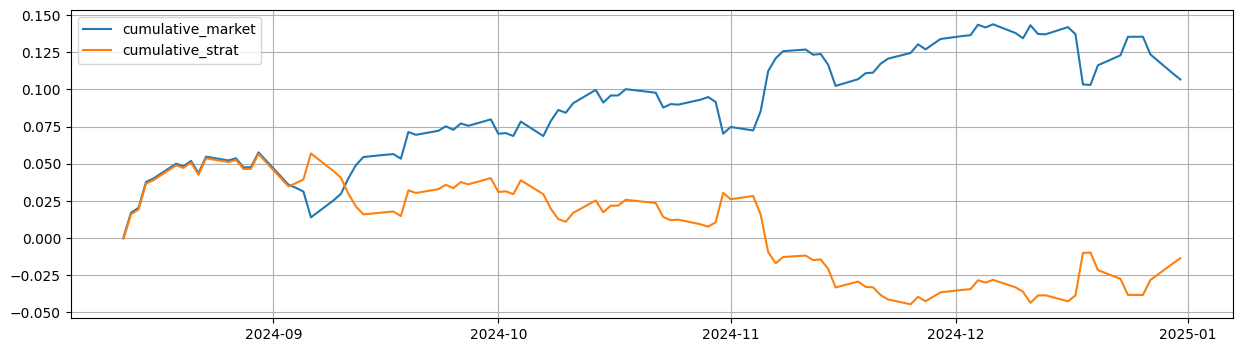

In [ ]:
TICKER = 'SPY' 
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
LOOKBACK = 100


def get_data():
    start = dt.datetime(1980,1,1)
    end = dt.datetime(2025,1,1)
    df = yf.download(TICKER, start, end)
    df.columns = df.columns.get_level_values(0) # eviter les problèmes d'indexage (enleve la ligne TICKER)
    
    # on ne que prendre le troncon qui nous interesse
    return df.iloc[-LOOKBACK:, :]


def add_macd(df, fast, slow, span):
    df['MACD_fast'] = df['Close'].ewm(span = fast).mean()
    df['MACD_slow'] = df['Close'].ewm(span = slow).mean()

    # MACDline et signal
    df['MACD_line'] = df['MACD_fast'] - df['MACD_slow'] # on capte les tendances
    df['MACD_signal'] = df['MACD_line'].ewm(span = span).mean() #trop de bruits donc on la lisse et on regarde line /à signal
    
    # un histogramme pour directement voir les tendances
    df['hist'] = df['MACD_line'] - df['MACD_signal']
    return df.dropna()


def add_strat(df):
    df['signal'] = np.where(df['MACD_line'] > df['MACD_signal'], 1, -1)
    return df


def test_strat(df):

    # rendement des strats
    df['market_returns'] = df['Close'].pct_change().fillna(0)
    df['strat_return'] = df['market_returns'] * df['signal'].shift(1)

    # cumulatif des strats
    df['cumulative_market'] = (1 + df['market_returns']).cumprod() - 1
    df['cumulative_strat'] = (1 + df['strat_return']).cumprod() - 1
    return df.dropna()


df = get_data()
df = add_macd(df, MACD_FAST, MACD_SLOW, MACD_SPAN)
df = add_strat(df)
df = test_strat(df)

# Visualiser les MACDs
plt.figure(figsize = (15,4))
plt.plot(df['MACD_line'])
plt.plot(df.index, df['MACD_signal'])
plt.bar(df.index, df['hist']) # obliger de mettre l'axe X avec plt.bar()
plt.grid()
plt.legend(['MACD_line', 'MACD_signal', 'hist'])

# Visulaser le cumulatif
plt.figure(figsize = (15,4))
plt.plot(df['cumulative_market'])
plt.plot(df['cumulative_strat'])
plt.legend(['cumulative_market', 'cumulative_strat'])
plt.grid()


